# Differential Gene Expression Analysis of Acute Myeloid Leukemia and Acute Lymphoblastics Leukemia

## Objective
This analysis is a part of the secondary aim of this analysis project to understand the gene expression differences between two leukemia classes: Acute Myeloid Leukemia (AML) and Acute Lymphoblastics Leukemia (ALL).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

## Importing data and preprocessing

In [2]:
trainData = pd.read_csv("/Users/maitreepatel/Desktop/microarrayCancerPrediction/data_set_ALL_AML_train.csv")
testData = pd.read_csv("/Users/maitreepatel/Desktop/microarrayCancerPrediction/data_set_ALL_AML_independent.csv")

# Removing columns with "call.x"
# From training data
colsToRemoveTrain = [cols for cols in trainData if 'call' in cols]
trainData = trainData.drop(colsToRemoveTrain, axis=1)

# Removing from test data
colsToRemoveTest = [cols for cols in testData if 'call' in cols]
testData = testData.drop(colsToRemoveTest, axis=1)

# Since we are classifying patients (i.e. AML versus ALL) and predicting using gene expression,
# We transpose the data
X_train = trainData.transpose()
X_test = testData.transpose()

# Since both gene description and accession are now column-wise,
# setting accessing as columns and removing the gene description
X_train.columns = X_train.iloc[1]
X_train = X_train.iloc[2:].reset_index(drop=True)

X_test.columns = X_test.iloc[1]
X_test = X_test.iloc[2:].reset_index(drop=True)

countsData = pd.concat([X_train, X_test], ignore_index=True, axis=0)
affymetricProbeCols = [cols for cols in countsData if 'AFFX' in cols]
countsData = countsData.drop(affymetricProbeCols, axis=1)
countsData

Gene Accession Number,hum_alu_at,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,15091,151,72,281,36,-299,57,186,1647,137,...,185,511,-125,389,-37,793,329,36,191,-37
1,11038,263,21,250,43,-103,169,219,2043,188,...,169,837,-36,442,-17,782,295,11,76,-14
2,16692,88,-27,358,42,142,359,237,1997,91,...,315,1199,33,168,52,1138,777,41,228,-41
3,15763,484,61,118,39,-11,274,245,2128,-82,...,240,835,218,174,-110,627,170,-50,126,-91
4,18128,118,16,197,39,237,311,186,1608,204,...,156,649,57,504,-26,250,314,14,56,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,22818,316,0,105,104,-76,38,261,1397,60,...,92,532,-34,239,-78,707,354,-22,260,5
68,39323,228,36,106,113,19,141,165,1030,73,...,63,297,36,358,2,423,41,0,1777,-49
69,15689,395,73,334,73,417,259,359,2656,318,...,130,639,-27,548,-39,809,445,-2,210,16
70,41570,311,-56,235,46,845,168,517,3570,92,...,84,1141,-121,197,-108,466,349,0,284,-73


In [3]:
metadata = pd.read_csv("/Users/maitreepatel/Desktop/microarrayCancerPrediction/actual.csv")
metadata.head()

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL


## Data QC and exploration

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

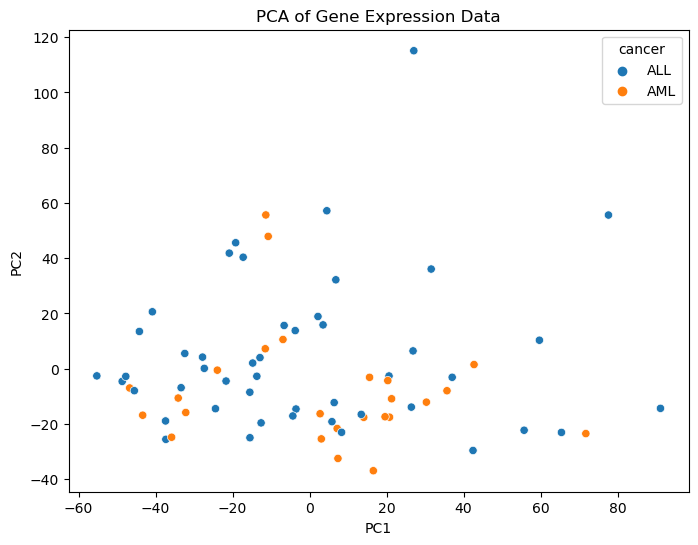

In [5]:
# PCA for QC
scaler = StandardScaler()
countsData_scaled = scaler.fit_transform(countsData)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(countsData_scaled)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['cancer'] = metadata['cancer']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cancer', data=pca_df)
plt.title('PCA of Gene Expression Data')
plt.show()

### Exploring distribution of gene expression
#### Total counts per Sample

In [6]:
# calcualte total counts per sample and log transform counts
totalCounts = pd.DataFrame(countsData.sum(axis=1))
totalCounts

,0
0,4428725.0
1,4803225.0
2,4821731.0
3,4176333.0
4,4737152.0
...,...
67,3874752.0
68,3706273.0
69,5076164.0
70,4820610.0


<BarContainer object of 72 artists>

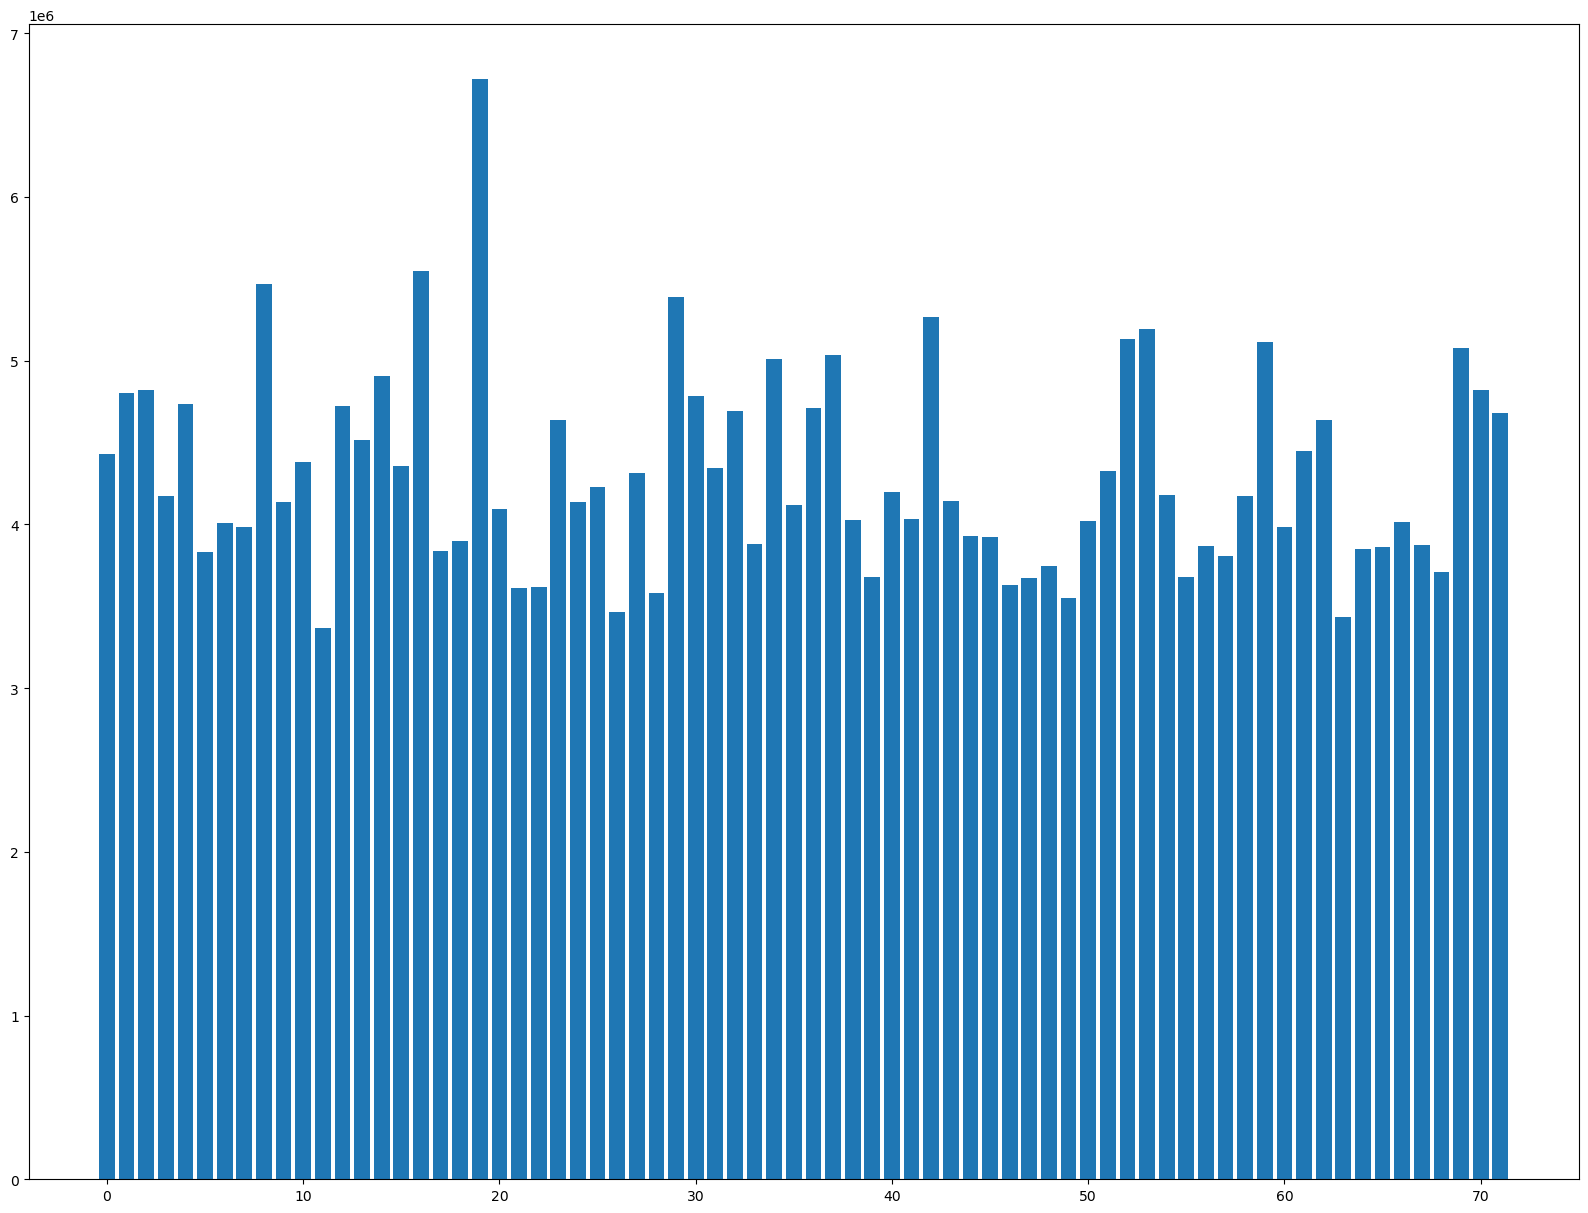

In [7]:
plt.figure(figsize=(20, 15))
plt.bar(totalCounts.index, totalCounts[0])

The folowing graph represents total counts per sample representing sequencing depth, this data shows variation in sequencing depth. Ideally, we would want amost equal sequencing depth across the samples.
#### Assesing variability in the counts data

In [8]:
from sklearn.preprocessing import StandardScaler

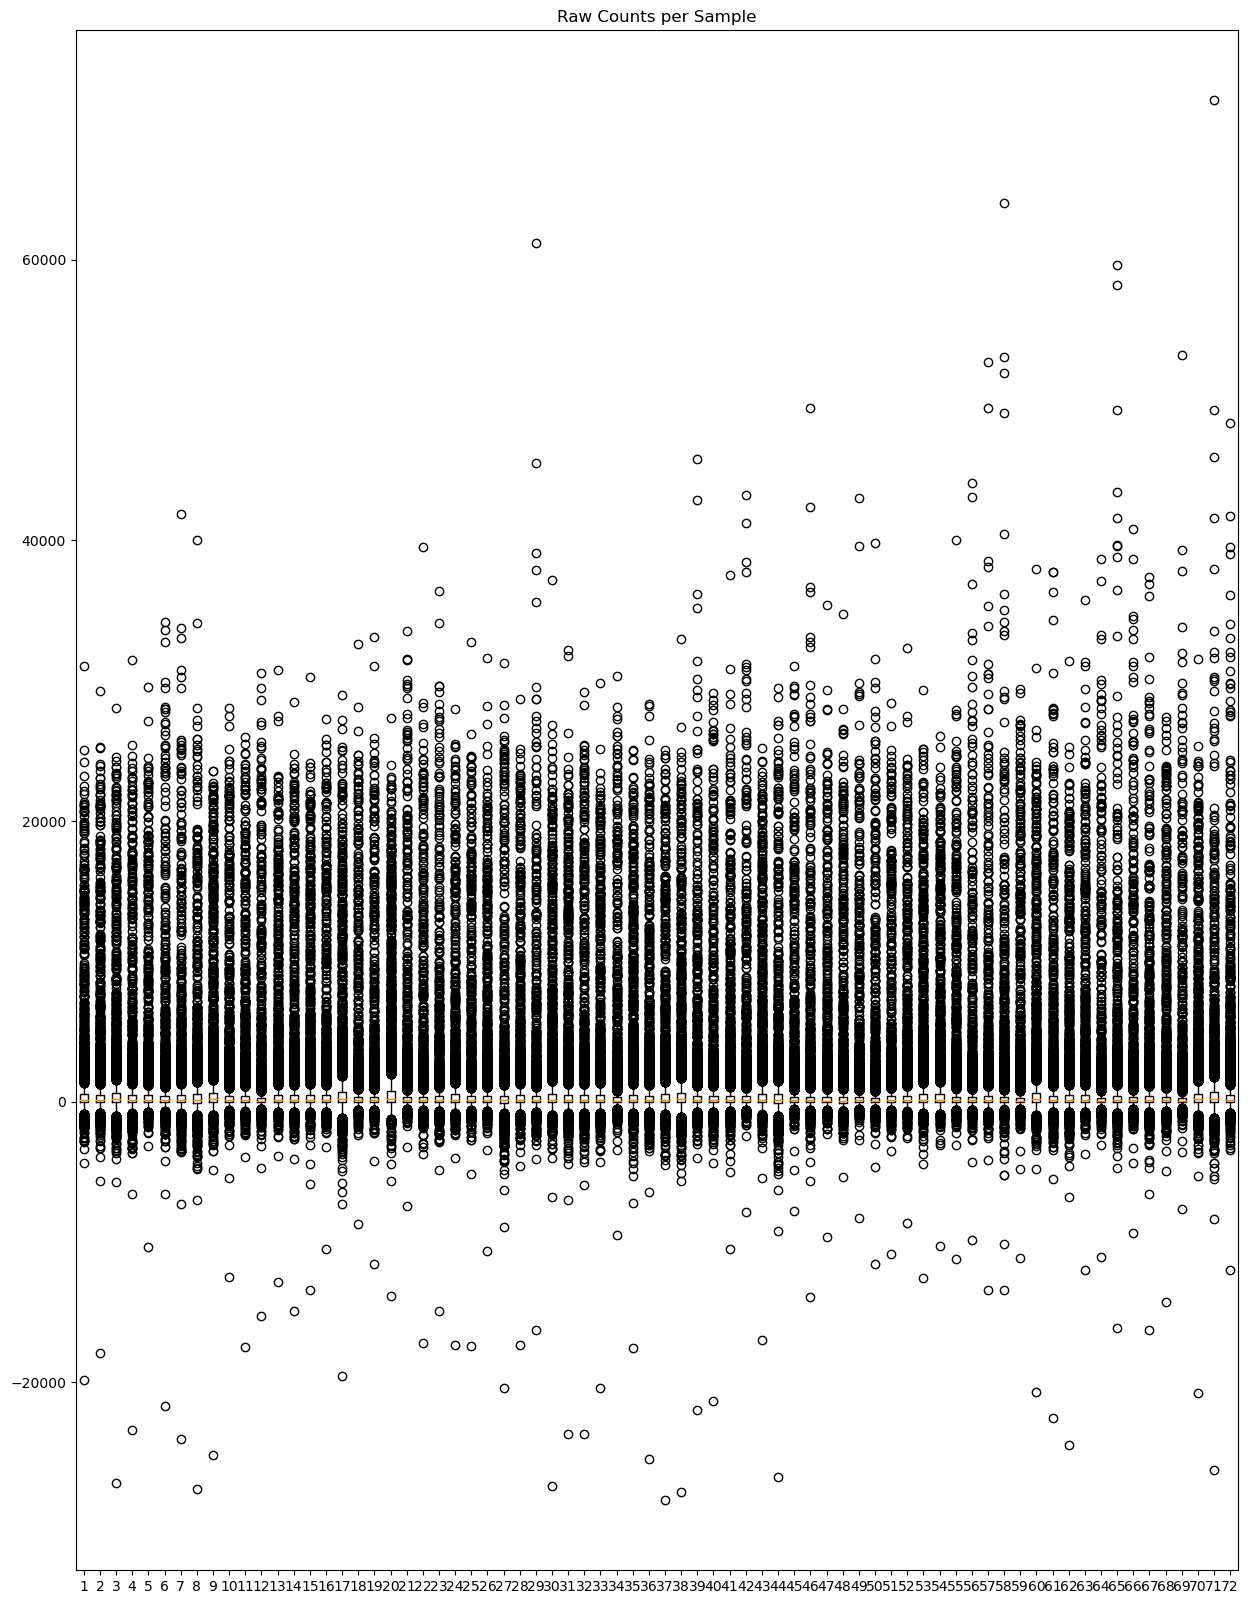

In [9]:
plt.figure(figsize=(15,20))
plt.boxplot(countsData.transpose())
plt.title("Raw Counts per Sample")
plt.show()

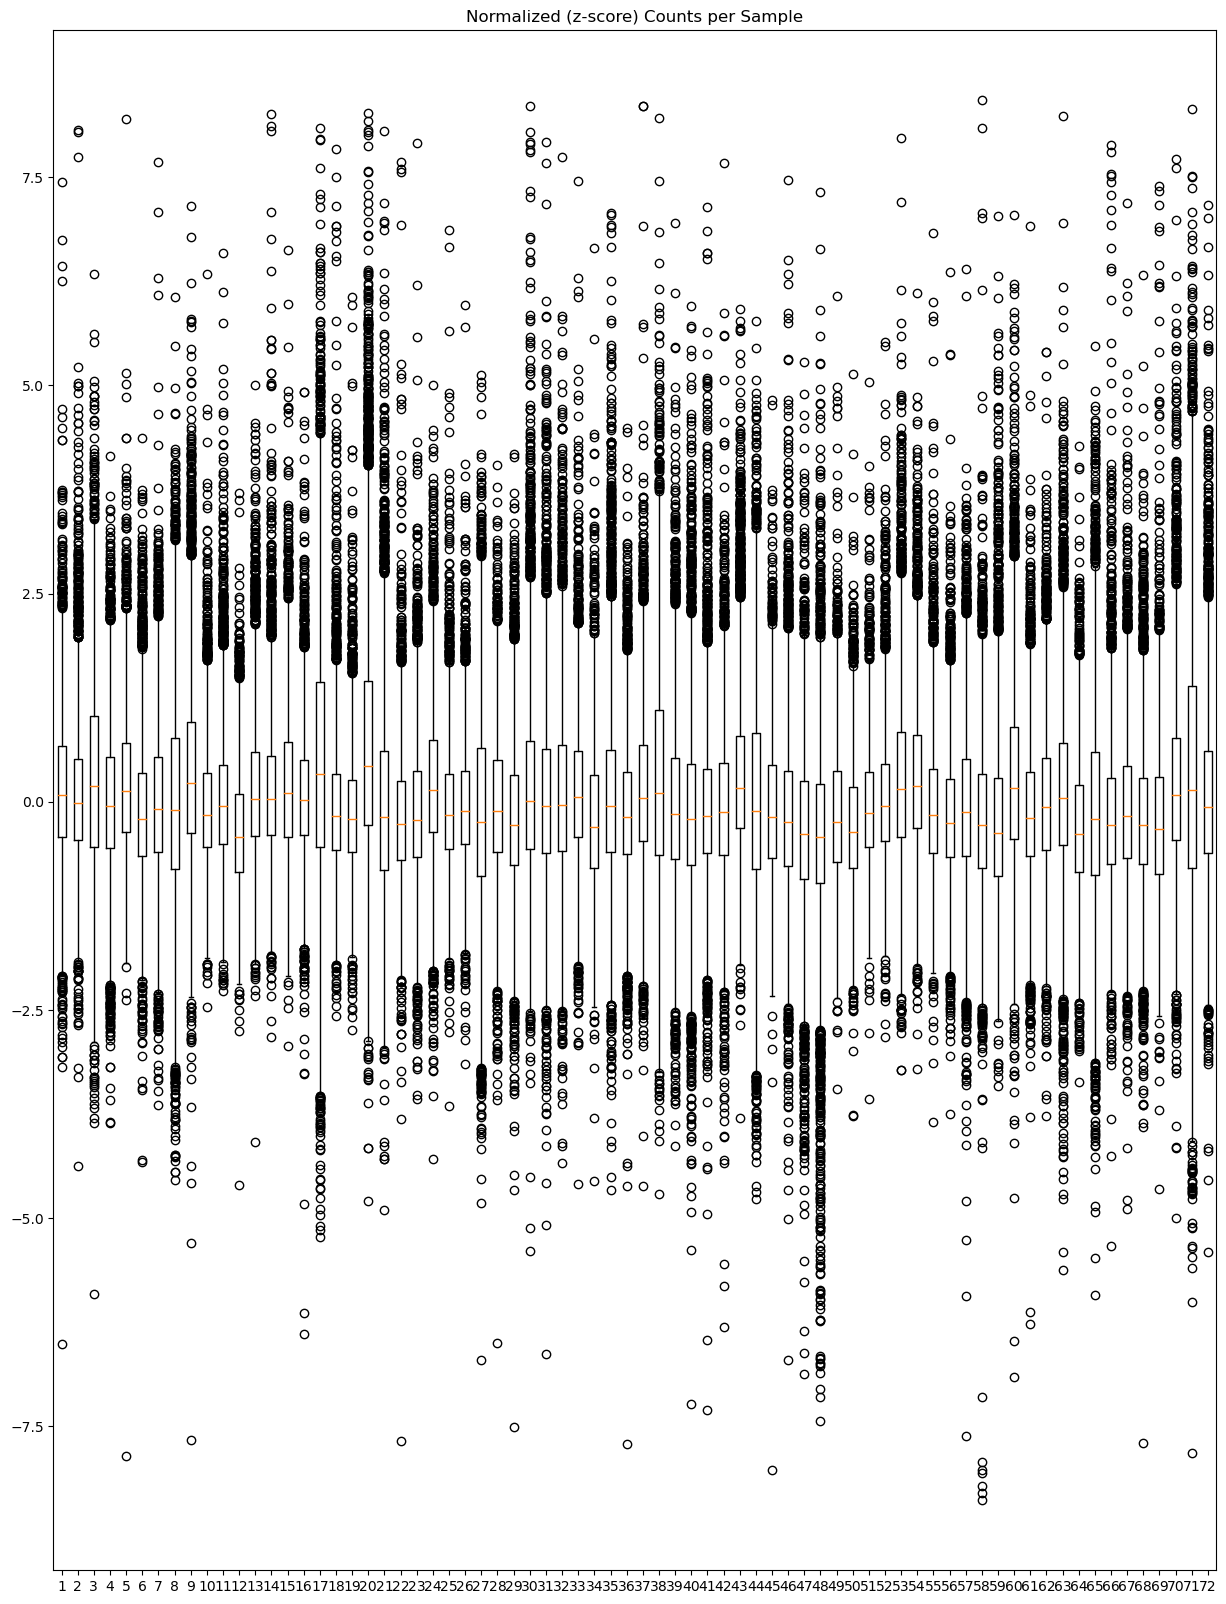

In [10]:
# Plotting normalized data
plt.figure(figsize=(15,20))
plt.boxplot(countsData_scaled.transpose())
plt.title("Normalized (z-score) Counts per Sample")
plt.show()

Interpretting above plots:
- **Highly variable counts values** with samples (after normalization)
- **Negative counts** data (before normalization)
    - Negative counts in microarray could have arisen due to preprocessing steps by the Golub et al 1999 study.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


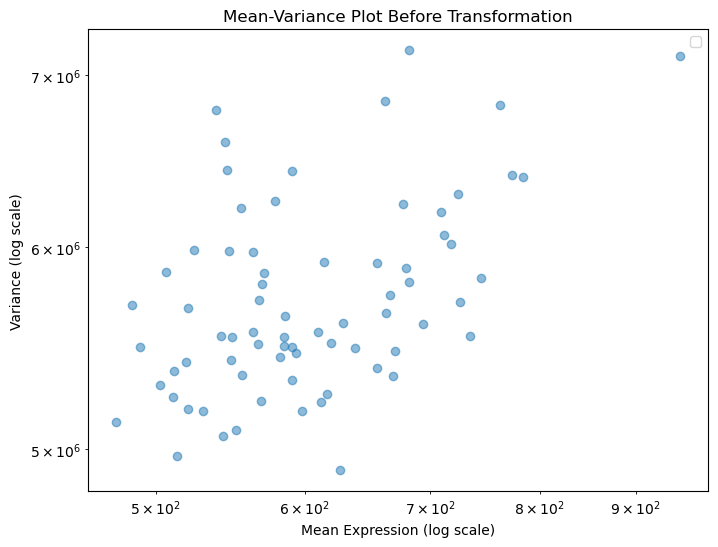

In [11]:
means = countsData.mean(axis=1)
variances = countsData.var(axis=1)

# Plot Mean-Variance relationship
plt.figure(figsize=(8, 6))
plt.scatter(means, variances, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean Expression (log scale)')
plt.ylabel('Variance (log scale)')
plt.title('Mean-Variance Plot Before Transformation')
plt.legend()
plt.show()

The mean-variance plot does not show a visible trend in the scatter of data points and indicates somewhat equal spread. Therefore variance is stabilized in the data and no correction was performed for this analysis.
#### Heirarchal clustering

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage

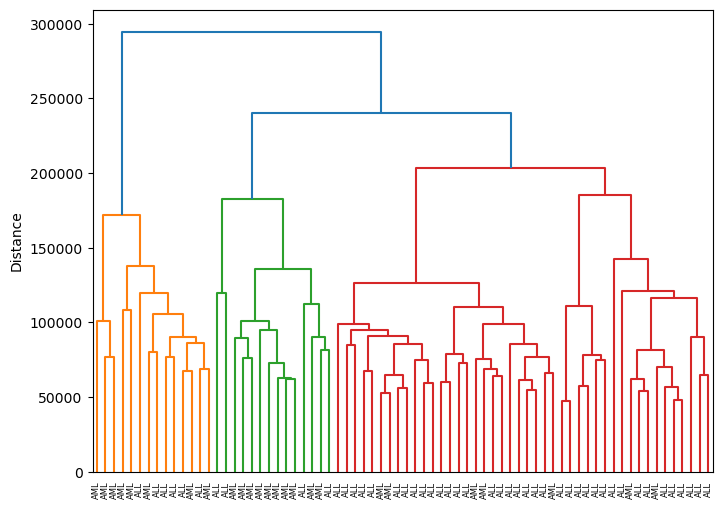

In [13]:
# perform hierarchical clustering and create dendrogram
h_clustering = linkage(countsData, 'ward')
plt.figure(figsize=(8, 6))
dendrogram(h_clustering, labels=metadata['cancer'].values)
plt.xticks(rotation=90)
plt.ylabel('Distance')
plt.show()

In [14]:
metadata

,patient,cancer
0,1,ALL
1,2,ALL
2,3,ALL
3,4,ALL
4,5,ALL
...,...,...
67,68,ALL
68,69,ALL
69,70,ALL
70,71,ALL


In [39]:
countsData = countsData.apply(pd.to_numeric, errors='coerce')
minVal = min(countsData.values.max(),  # Max for ALL
                countsData.values.min())
minVal

-28400

In [40]:
countsData.head()

Gene Accession Number,hum_alu_at,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,15091,151,72,281,36,-299,57,186,1647,137,...,185,511,-125,389,-37,793,329,36,191,-37
1,11038,263,21,250,43,-103,169,219,2043,188,...,169,837,-36,442,-17,782,295,11,76,-14
2,16692,88,-27,358,42,142,359,237,1997,91,...,315,1199,33,168,52,1138,777,41,228,-41
3,15763,484,61,118,39,-11,274,245,2128,-82,...,240,835,218,174,-110,627,170,-50,126,-91
4,18128,118,16,197,39,237,311,186,1608,204,...,156,649,57,504,-26,250,314,14,56,-25


In [41]:
countsData = countsData+28400
countsData.head()

Gene Accession Number,hum_alu_at,A28102_at,AB000114_at,AB000115_at,AB000220_at,AB000409_at,AB000449_at,AB000450_at,AB000460_at,AB000462_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,43491,28551,28472,28681,28436,28101,28457,28586,30047,28537,...,28585,28911,28275,28789,28363,29193,28729,28436,28591,28363
1,39438,28663,28421,28650,28443,28297,28569,28619,30443,28588,...,28569,29237,28364,28842,28383,29182,28695,28411,28476,28386
2,45092,28488,28373,28758,28442,28542,28759,28637,30397,28491,...,28715,29599,28433,28568,28452,29538,29177,28441,28628,28359
3,44163,28884,28461,28518,28439,28389,28674,28645,30528,28318,...,28640,29235,28618,28574,28290,29027,28570,28350,28526,28309
4,46528,28518,28416,28597,28439,28637,28711,28586,30008,28604,...,28556,29049,28457,28904,28374,28650,28714,28414,28456,28375


In [15]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection

In [16]:
# First, Merging data
merged = pd.concat([countsData, metadata], ignore_index=True, axis=1)
# Splitting data into the two cancer classes
ALL = pd.DataFrame(countsData[merged.iloc[:,7072] == "ALL"])
AML = pd.DataFrame(countsData[merged.iloc[:,7072] == "AML"])
ALL = ALL.apply(pd.to_numeric, errors='coerce')
AML = AML.apply(pd.to_numeric, errors='coerce')
print(ALL.shape)
print(AML.shape)

(47, 7071)
(25, 7071)


In [ ]:
# calculating log2fold change

In [71]:
meanALL = ALL.mean(axis=0)
meanAML = AML.mean(axis=0)

meanAML = pd.to_numeric(meanAML, errors='coerce')
meanALL = pd.to_numeric(meanALL, errors='coerce')
print(meanAML.shape, meanALL.shape)

(7071,) (7071,)


In [77]:
log2fc = np.log2((meanAML + 1) / (meanALL + 1))
log2fc

Gene Accession Number
hum_alu_at     0.183905
A28102_at      0.241594
AB000114_at   -0.471270
AB000115_at    0.080447
AB000220_at   -0.244255
                 ...   
X83863_at      0.263449
Z17240_at     -0.004818
L49218_f_at   -0.998560
M71243_f_at    1.028952
Z78285_f_at   -1.429980
Length: 7071, dtype: float64

In [107]:
log2fc_df = pd.DataFrame({"Gene": log2fc.index, "Log2FC": log2fc})
log2fc_df

log2fc_df = log2fc_df.sort_values("Log2FC", ascending=False)

# Display top differentially expressed genes
print(log2fc_df)

                                   Gene     Log2FC
Gene Accession Number                             
L06845_at                     L06845_at  11.312892
U48436_s_at                 U48436_s_at   7.756223
J03040_at                     J03040_at   7.315487
M72885_rna1_s_at       M72885_rna1_s_at   6.735347
L10386_at                     L10386_at   6.667152
...                                 ...        ...
U03735_f_at                 U03735_f_at        NaN
U10689_f_at                 U10689_f_at        NaN
U22029_f_at                 U22029_f_at        NaN
X00090_f_at                 X00090_f_at        NaN
AC002076_cds2_at       AC002076_cds2_at        NaN

[7071 rows x 2 columns]


In [108]:
resultsTTest = []

for gene in ALL.columns:
    t_stat, p_val = ttest_ind(ALL[gene], AML[gene], equal_var=False)  # Perform t-test
    resultsTTest.append((gene, t_stat, p_val))
    
dfResults = pd.DataFrame(resultsTTest, columns=['Gene Accession Number', 'T_Value', 'P_Value'])

# correcting for multiple testing
sig, adj_p_values = fdrcorrection(dfResults['P_Value'])
sigGenes = dfResults[sig & (adj_p_values < 0.05)]
sigGenes = sigGenes.sort_values(by='P_Value')
#sigGenes
dfResults

,Gene Accession Number,T_Value,P_Value
0,hum_alu_at,-1.142366,0.259928
1,A28102_at,-0.962438,0.341383
2,AB000114_at,0.649410,0.518445
3,AB000115_at,-0.184311,0.854477
4,AB000220_at,0.605963,0.547651
...,...,...,...
7066,X83863_at,-1.243599,0.220572
7067,Z17240_at,0.021985,0.982527
7068,L49218_f_at,0.648983,0.518569
7069,M71243_f_at,-1.824192,0.077976


In [109]:
dfResults.set_index("Gene Accession Number", inplace=True)
merged_df = log2fc_df.join(dfResults, how="inner")

In [110]:
print(merged_df)

                                   Gene     Log2FC   T_Value   P_Value
Gene Accession Number                                                 
L06845_at                     L06845_at  11.312892  2.366935  0.022150
U48436_s_at                 U48436_s_at   7.756223 -0.791518  0.432071
J03040_at                     J03040_at   7.315487 -1.578106  0.125436
M72885_rna1_s_at       M72885_rna1_s_at   6.735347 -1.565511  0.130163
L10386_at                     L10386_at   6.667152  2.169648  0.037405
...                                 ...        ...       ...       ...
U03735_f_at                 U03735_f_at        NaN -1.975640  0.053555
U10689_f_at                 U10689_f_at        NaN -0.858494  0.394092
U22029_f_at                 U22029_f_at        NaN -1.569546  0.122149
X00090_f_at                 X00090_f_at        NaN  1.631070  0.108139
AC002076_cds2_at       AC002076_cds2_at        NaN -1.325117  0.189686

[7071 rows x 4 columns]


In [119]:
log_pvals = -np.log10(merged_df["P_Value"])  # Assuming p-values are already merged

# Define significance threshold
p_threshold = 0.05  # Common significance threshold
log2fc_threshold = 1  # Log2FC cutoff for biological significance

# Define colors based on Log2FC and significance
colors = np.where((merged_df["Log2FC"] > log2fc_threshold) & (merged_df["P_Value"] < p_threshold), 'red',  # Upregulated (Significant)
         np.where((merged_df["Log2FC"] < -log2fc_threshold) & (merged_df["P_Value"] < p_threshold), 'blue',  # Downregulated (Significant)
         'gray'))  # Not significant
colors

array(['red', 'gray', 'gray', ..., 'gray', 'gray', 'gray'], dtype='<U4')

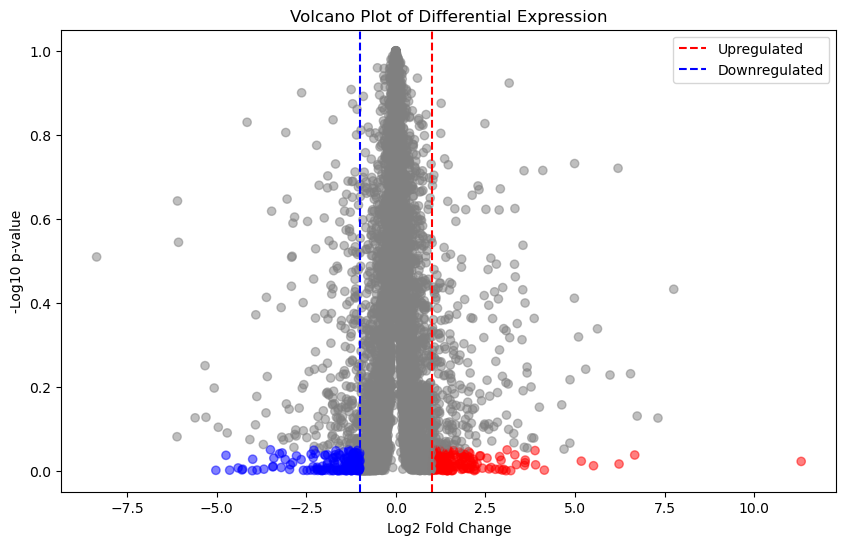

In [120]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_df["Log2FC"], merged_df["P_Value"], alpha=0.5, c=colors)
plt.axvline(1, color='red', linestyle='--', label='Upregulated')
plt.axvline(-1, color='blue', linestyle='--', label='Downregulated')
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10 p-value")
plt.title("Volcano Plot of Differential Expression")
plt.legend()
plt.show()

In [19]:
topGenes = pd.Series(sigGenes["Gene Accession Number"])
topGenes = topGenes.astype(str)
topGenes = topGenes.str.strip()

#AMLnorm = pd.DataFrame(scaler.fit_transform(AML))
#AMLnorm.columns = AML.columns

#ALLnorm = pd.DataFrame(scaler.fit_transform(ALL))
#ALLnorm.columns = ALL.columns

AMLTop = AML[topGenes]
ALLTop = ALL[topGenes]

In [20]:
type(topGenes)

pandas.core.series.Series

In [ ]:
#colors = metadata['cancer'].map({'ALL': 'blue', 'AML': 'red'})

In [21]:
AMLTop = AMLTop.apply(pd.to_numeric, errors='coerce')

In [22]:
ALLTop = ALLTop.apply(pd.to_numeric, errors='coerce')

In [24]:
maxAbsVal = max(abs(ALLTop.values.max()),  # Max for ALL
                abs(ALLTop.values.min()),  
                abs(AMLTop.values.max()),  # Max for AML
                abs(AMLTop.values.min()))

minAbsVal = min(abs(ALLTop.values.max()),  # Max for ALL
                abs(ALLTop.values.min()),  
                abs(AMLTop.values.max()),  # Max for AML
                abs(AMLTop.values.min()))
print(maxAbsVal, minAbsVal)

16492 1067


<Figure size 1200x800 with 0 Axes>

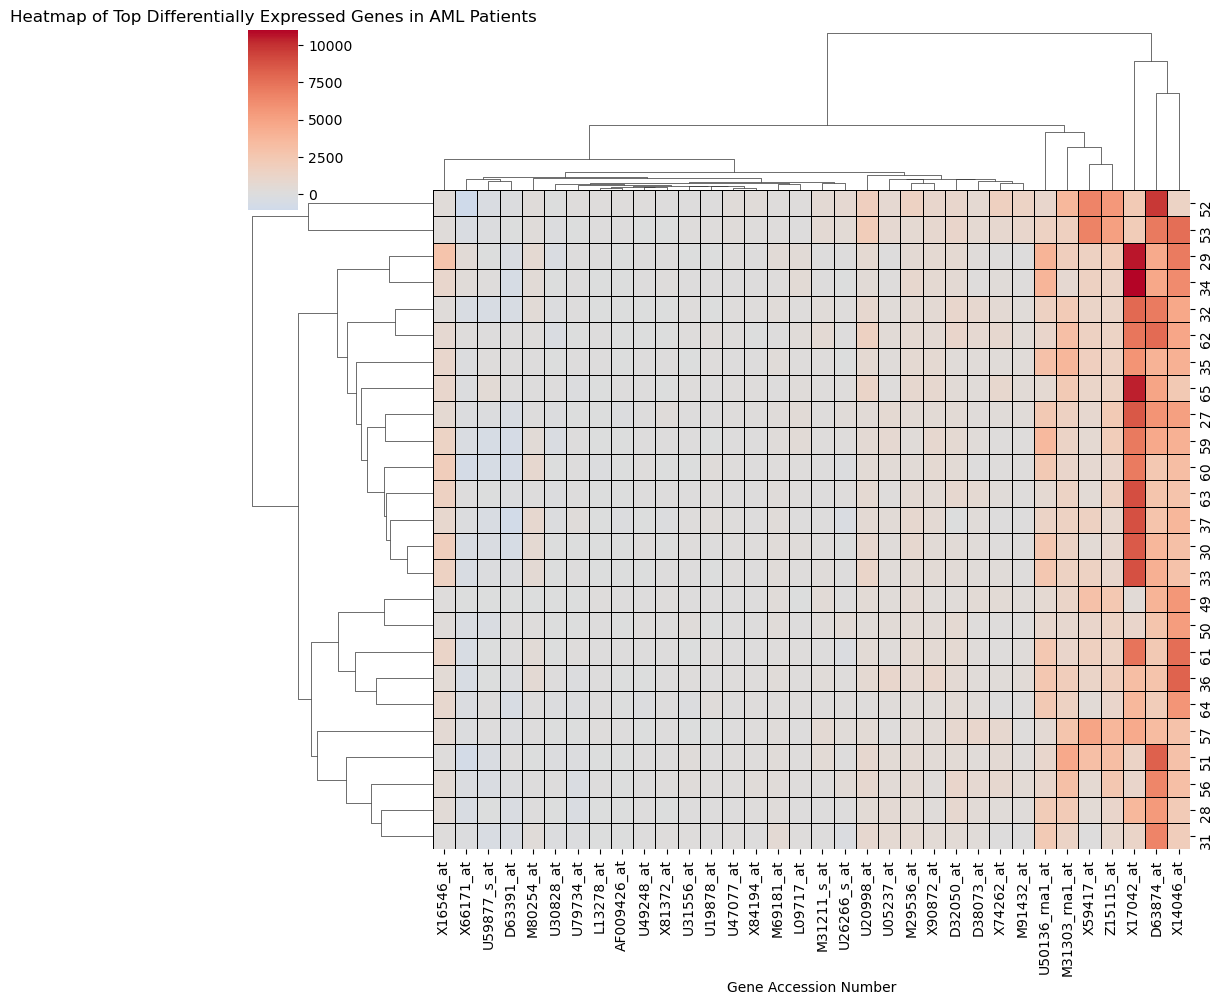

In [31]:
plt.figure(figsize=(12,8))
sns.clustermap(AMLTop,
            cmap="coolwarm",
            center=0,
            linewidth = 0.5,
            linecolor = "black")
plt.title("Heatmap of Top Differentially Expressed Genes in AML Patients")
plt.savefig("AMLheatmap.png")
plt.show()

<Figure size 1200x800 with 0 Axes>

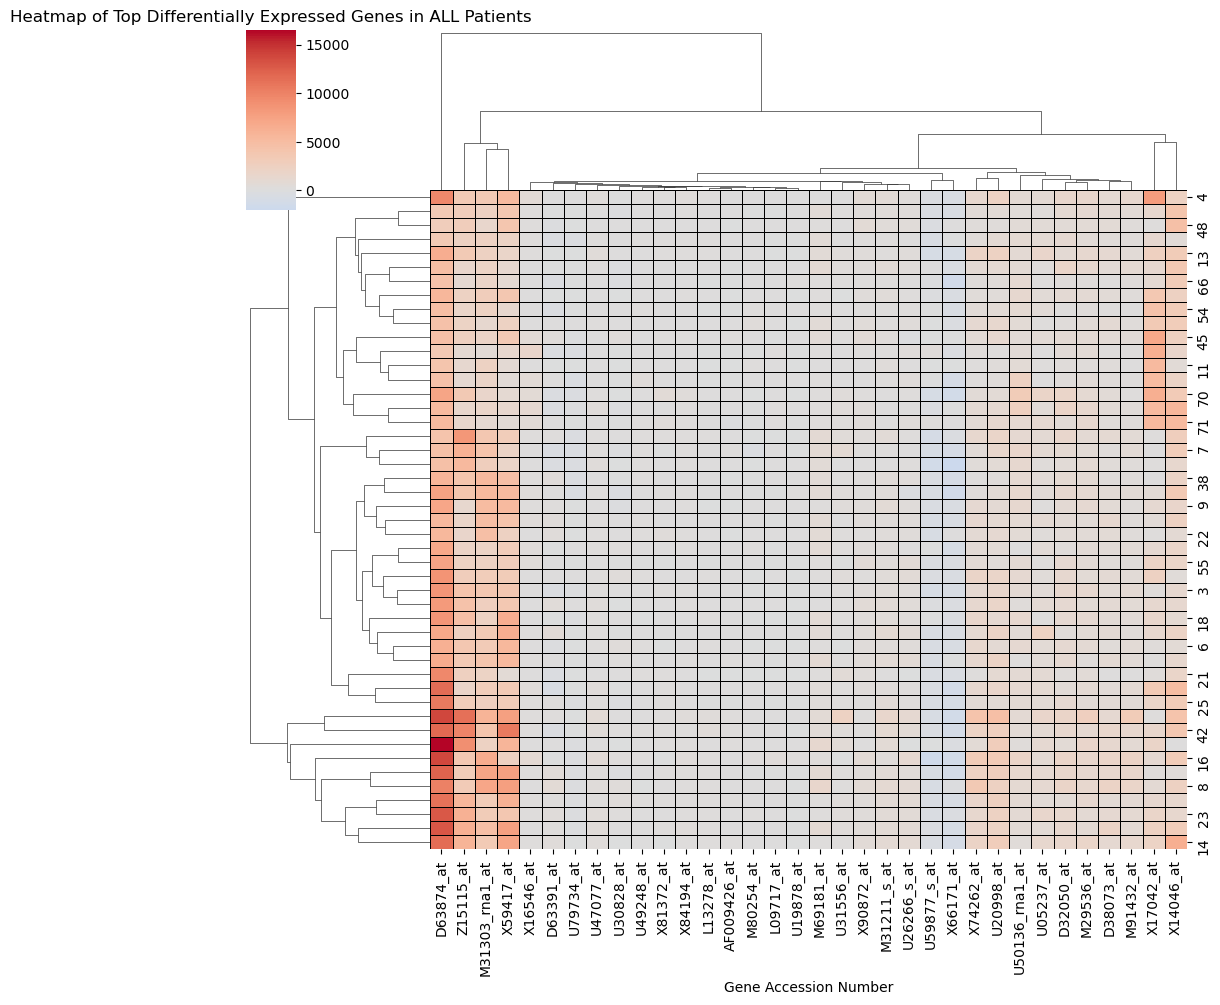

In [26]:
plt.figure(figsize=(12,8))
sns.clustermap(ALLTop,
            cmap="coolwarm",
            center=0,
            linewidth = 0.5,
            linecolor = "black")
plt.title("Heatmap of Top Differentially Expressed Genes in ALL Patients")
plt.savefig("ALLheatmap.png")
plt.show()
